In [1]:
__author__ = "Victor Xu"
__email__ = "victor.c.xu@gmail.com"
__website__ = "victorxu.me"

__copyright__ = "Copyright 2019, Victor Xu"

In [2]:
import warnings
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from src.top_k_accuracy import top_k_accuracy_score

# Data Modeling
#### Spliting train test data

In [3]:
engine = create_engine("sqlite:///db/nba.db", echo=False)
with engine.connect() as conn:
    data = pd.read_sql('player_stats', conn, index_col='nba_id')
    
data.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min,espn_position
nba_id,,,,,,,,,,,,,,,,,,,,
101106,0.666666,0.277778,0.055556,0.000000,0.000000,0.000000,36,0.000000,0.999990,0.000000,0.0,0.000000,0.000000,1,10.1,26.9,7.2,2.0,350.758333,C
101107,0.188940,0.173579,0.052227,0.132104,0.062980,0.390169,651,0.619047,0.238095,0.000000,0.0,0.047619,0.095238,21,3.5,14.5,4.4,2.9,4139.115000,PF
101108,0.100418,0.211994,0.199442,0.030683,0.051604,0.405858,717,0.533333,0.333333,0.066667,0.0,0.000000,0.066667,15,1.9,13.1,24.1,5.4,3703.331667,PG
101108,0.100418,0.211994,0.199442,0.030683,0.051604,0.405858,717,0.533333,0.333333,0.066667,0.0,0.000000,0.066667,15,1.9,13.1,24.1,5.4,3703.331667,PG
101109,0.134328,0.179104,0.238806,0.037313,0.044776,0.365672,134,0.333332,0.333332,0.333332,0.0,0.000000,0.000000,3,1.4,8.4,13.7,3.0,1744.088333,PG


#### Reserving data for API testing
Before spliting the dataset we'll reserve a few rows of data to do final
testing of the API. This ensure reserved rows never gets leaked into the training data.

| Name | NBA ID   | Position |Note|
|------|------|------|------|
|Lebron James|2544|Small Forward|Play style not bound by position label|
|Pascal Siakam|1627783|Power Forward|Standard power foward|
|DeMarcus Cousins|202326|Center|Standard center|
|Damian Lillard|203081|Point Guard|Standard point guard|
|Anfernee Simons|1629014|Shooting Guard|Rookie with little data|



In [4]:
print("Shape of data before dropping:", data.shape)
labels_to_lookup = ['2544','1627783','202326','203081','1629014']

# Drop duplicates because the same player will have multiple seasons of play data.
# Each in a different column
idx_to_drop = [data.drop_duplicates().index.get_loc(label) for label in labels_to_lookup] 

data_api_test = data.iloc[idx_to_drop,:]
data = data.iloc[[i for i in range(len(data)) if i not in idx_to_drop]]

with engine.connect() as conn:
    data_api_test.to_sql("api_test", conn)

print("Shape of data after dropping:", data.shape)

Shape of data before dropping: (638, 20)
Shape of data after dropping: (633, 20)


In [5]:
from sklearn.model_selection import train_test_split

# Dropping players with less than 50 shots attempts
data = data[data.fga >= 50]

X = data.drop('espn_position', axis=1)
y = data[['espn_position']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Manually encode the labels to make it more meaningful for the confusion matrix later
label_encoder_dict = dict([
    ("C",0),
    ("PG",1),
    ("SG",2),
    ("SF",3),
    ("PF",4)
])

y_train = y_train.espn_position.map(label_encoder_dict).values
y_test = y_test.espn_position.map(label_encoder_dict).values

print('X_train:',X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (429, 19)
y_train: (429,)
X_test: (144, 19)
y_test: (144,)


In [6]:
X_train.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min
nba_id,,,,,,,,,,,,,,,,,,,
1629019,0.409266,0.094595,0.241313,0.021236,0.021236,0.212355,518,0.806451,0.096774,0.048387,0.00000,0.000000,0.048387,62,1.0,5.5,3.9,0.9,1458.563333
202709,0.176471,0.176471,0.340074,0.031250,0.040441,0.235294,544,0.636363,0.227273,0.090909,0.00000,0.000000,0.045455,22,1.7,10.5,13.1,3.9,4273.400000
1627885,0.588652,0.172577,0.035461,0.047281,0.028369,0.127660,423,0.682927,0.219512,0.000000,0.04878,0.000000,0.048780,41,2.2,12.8,11.6,6.2,1814.446667
203121,0.037267,0.060041,0.153209,0.066253,0.076605,0.606625,483,0.133333,0.066667,0.200000,0.00000,0.066667,0.533333,15,0.8,6.7,6.7,1.8,3701.945000
101139,0.148387,0.090323,0.109677,0.067742,0.090323,0.493548,310,0.588235,0.176470,0.117647,0.00000,0.058823,0.058823,17,0.9,8.8,4.3,2.8,1150.968333


A big chunk of players do not have meaningful number of blocks. We will keep these features for now and see if the models think they are important later

In [7]:
y_train[:10]

array([2, 1, 1, 3, 3, 2, 1, 4, 1, 1])

### Baseline Predictor /w decision tree & PCA

We are going to use a simple cross validated decision tree as the baseline predictor.

In [8]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA

pipeline = Pipeline([('standarize', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', DecisionTreeClassifier(class_weight='balanced'))])

param_grid = {"pca__n_components":[5,10,15,18],
              "clf__max_depth":[5,10,15]}

cv = StratifiedKFold(5, shuffle=True)

dt_grid_search = GridSearchCV(pipeline, 
                              param_grid, 
                              verbose=0, 
                              scoring='accuracy', 
                              cv=cv, 
                              n_jobs=-1)

dt_grid_search.fit(X_train, y_train);

baseline_score = dt_grid_search.score(X_test, y_test)
print("Baseline accuracy score is", baseline_score)

Baseline accuracy score is 0.6180555555555556


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [9]:
dt_grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('standarize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=18,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=15,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         ver

In [10]:
def draw_confusion_matrix(y_ground_truth, y_pred):
    """Plots confusion matrix given ground truth and predicted labels"""
    warnings.filterwarnings('ignore')

    cm = confusion_matrix(y_test, y_pred)

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(9, 7))
    heat_map = sns.heatmap(cm, 
                           annot=True, 
                           fmt="d", 
                           linewidths=1, 
                           ax=ax, 
                           cmap=sns.cubehelix_palette(50),
                           xticklabels=label_encoder_dict.keys(), 
                           yticklabels=label_encoder_dict.keys())

    heat_map.set_xlabel("Predicted Label")
    heat_map.set_ylabel("Ground Truth Label")

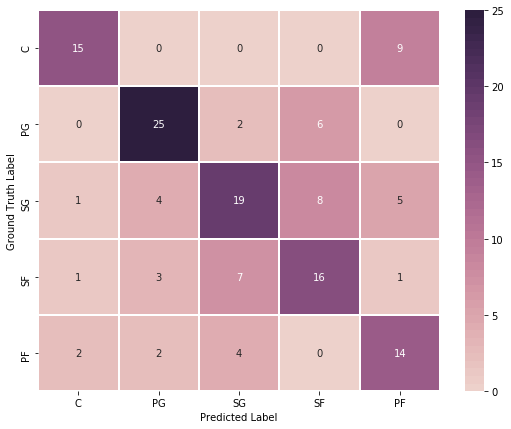

In [11]:
draw_confusion_matrix(y_test, dt_grid_search.predict(X_test))

### Multinomial Logistic Regression

Why choose it
    - Predicts probability distribution over k classes, which gives us insight on how close the player is to each position/role
    - Performs well when data is not well separated, which is going to be the case for us. The variance in NBA stat is often quite high

#### Examine Multicollinearity 

Unless extreme, multicollinearity won't affect prediction. It will, however, affect our ability to assert causation and make the model much less interpretable. Since we are only interested in prediction, it's therefore not a big concern but we'll have a look at the VIF just to see what we are dealing with.

In [12]:
# Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []
for idx, col in enumerate(X.columns):
    VIF_i = variance_inflation_factor(X.dropna().values, idx)
    vif_data.append([col, VIF_i])

display(pd.DataFrame(vif_data, columns=['Feature', "VIF"]).sort_values("VIF", ascending=False))

,Feature,VIF
7,block_res,6.148259e+11
0,shot_res,2.352855e+11
8,block_in_paint,1.575760e+11
5,shot_above_3,1.539324e+11
1,shot_in_paint,4.860428e+10
2,shot_mid_range,4.248118e+10
9,block_mid_range,1.403364e+10
12,block_above_3,9.844536e+09
4,shot_rcorner_3,6.066038e+09
3,shot_lcorner_3,6.058910e+09


Anything with VIF over 10 exhibits strong multicolinearity with other features, here we are dealing with many feature that has strong correlation with others.

Quickest way to solve this is in this dataset is probably with a combination of standarization, PCA and L1 regularization. 

In [13]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([('standarize', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', LogisticRegression(class_weight='balanced', 
                                                max_iter=10000,
                                                multi_class='multinomial',
                                                solver='saga'))])

param_grid = {"clf__penalty":['l1','l2','none'],
              "clf__C":[.5,.75,1,1.25],
              "pca__n_components":[5,10,15,18]}

scoring = {'Accuracy': make_scorer(accuracy_score), 
           'Balanced Accuracy': make_scorer(balanced_accuracy_score)}

cv = StratifiedKFold(5, shuffle=True)

lr_grid_search = GridSearchCV(pipeline, 
                              param_grid, 
                              verbose=0, 
                              scoring=scoring,
                              cv=cv,
                              n_jobs=-1,
                              refit='Balanced Accuracy')

lr_grid_search.fit(X_train, y_train);

lr_score = lr_grid_search.score(X_test, y_test)

print("Logistic regression accuracy score is %.2f" % lr_score)

Logistic regression accuracy score is 0.65


In [14]:
lr_grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('standarize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='none', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

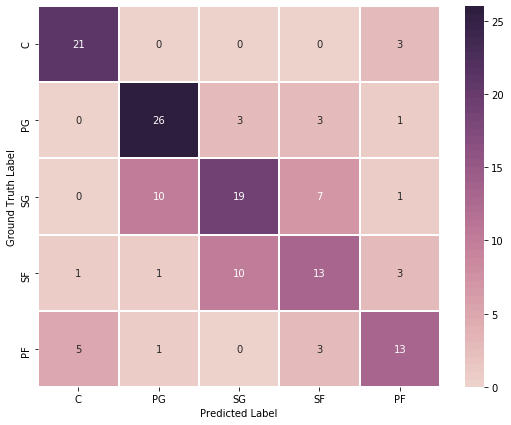

In [15]:
draw_confusion_matrix(y_test, lr_grid_search.predict(X_test))

This result is interesting because it shows that based on where a player shoots the ball, and his general stats, we can generally tell which type of player he is. 

Not surprisingly, the difference between a Point Guard and a Shooting Guard is subtle, as misclassification rates are somewhat high between the two groups.

The Power Forward position is also an interesting one, as it often gets misclassified with Center. This makes sense because they have more similar play styles, which is to always play near the restricted zone.

https://sports.stackexchange.com/questions/2172/what-are-the-differences-between-the-power-forward-and-center-positions

## Tree Based Methods

### Random Forest

Why Choose It
    - One of the best out of the box classifiers. It is non-parametric(don't assume underlying data distribution), which makes it robust to many kinds of data and does not require feature preprocessing. 
    - Pretty quick to train compared to XGBoost, which has many more parameters to tune.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('clf', RandomForestClassifier(n_jobs=-1, 
                                                       class_weight='balanced'))])

rf_parameter_grid = {'clf__n_estimators':[500],
                    'clf__max_depth':[8, 12, 16, 18],
                    'clf__min_samples_split':[2, 8, 12, 18]
                    }

rf_gridsearch = GridSearchCV(rf_pipeline, 
                             rf_parameter_grid, 
                             cv=cv, 
                             scoring=scoring, 
                             refit="Balanced Accuracy")

rf_gridsearch.fit(X_train, y_train)

rf_score = rf_gridsearch.score(X_test, y_test)
print("Random forest accuracy score is %.2f" % rf_score)

Random forest accuracy score is 0.73


In [17]:
rf_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=12,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

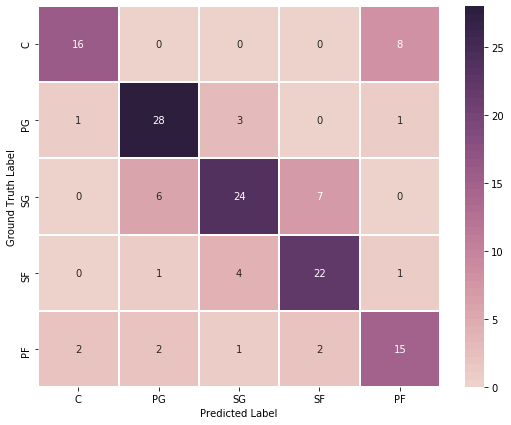

In [18]:
draw_confusion_matrix(y_test, rf_gridsearch.predict(X_test))

In this case, RF did not perform better than our Multinomial Logistic Regression Classifier. It made similar mistakes compared to the logistic regression model (confusing same types of players), and greater in quantity.

### Boosted Trees

#### XGBoost

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

xgb_pipeline = Pipeline([('xgb_clf', XGBClassifier(n_jobs=1, 
                                                   learning_rate=0.1, 
                                                   verbose=10))])

xgb_param_grid1 = {
    'xgb_clf__n_estimators':[75],
    'xgb_clf__gamma':[0, 0.5, 1],
    'xgb_clf__max_depth':[3, 6, 9],
    'xgb_clf__reg_alpha':[0, 0.5, 1], 
    'xgb_clf__reg_lambda':[0, 0.5, 1], 
}

cv = StratifiedKFold(5, shuffle=False)

xgb_grid_cv = GridSearchCV(xgb_pipeline, 
                           xgb_param_grid1, 
                           scoring=scoring, 
                           cv=cv, 
                           verbose=0, 
                           n_jobs=-1, 
                           refit='Balanced Accuracy')

xgb_grid_cv.fit(X_train, y_train)

xgb_score = xgb_grid_cv.score(X_test, y_test)

print("Random forest accuracy score is %.2f" % rf_score)

xgb_grid_cv.best_estimator_

Random forest accuracy score is 0.73


Pipeline(memory=None,
         steps=[('xgb_clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0.5, learning_rate=0.1,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=None,
                               n_estimators=75, n_jobs=1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1, verbose=10,
                               verbosity=1))],
         verbose=False)

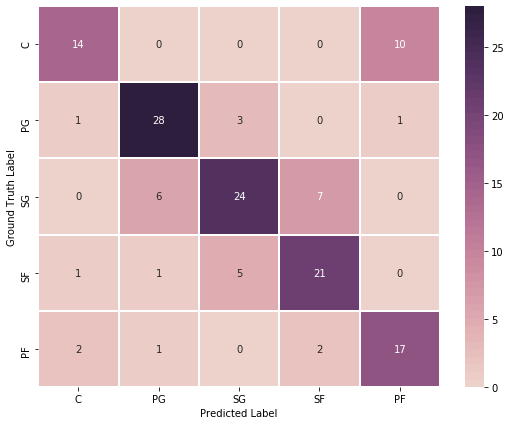

In [20]:
draw_confusion_matrix(y_test, xgb_grid_cv.predict(X_test))

## Model comparson

In [21]:
clfs = [("Decision Tree (Baseline)", dt_grid_search),
        ("XGBoost", xgb_grid_cv), 
        ("Random Forest", rf_gridsearch), 
        ("Logistic Regression", lr_grid_search)]

In [22]:
scores = []
for clf_name, clf in clfs:
    
    y_pred_proba = clf.predict_proba(X_test)
    
    clf_top_n_score = []
    
    # Balanced accuracy, which is the default scorer for Grid Search CV
    clf_top_n_score.append(clf.best_score_)
    
    for i in range(1,4):
        score = top_k_accuracy_score(y_test, y_pred_proba, i)
        clf_top_n_score.append(score)
    
    scores.append(clf_top_n_score)

score_names = ['Balanced Accuracy', 'Top 1 Accuracy', 'Top 2', 'Top 3']    

    
pd.DataFrame(scores, columns=score_names, index=[e[0] for e in clfs])

,Balanced Accuracy,Top 1 Accuracy,Top 2,Top 3
Decision Tree (Baseline),0.645688,0.618056,0.680556,0.847222
XGBoost,0.762800,0.722222,0.930556,0.979167
Random Forest,0.774016,0.729167,0.937500,0.972222
Logistic Regression,0.627519,0.638889,0.875000,0.979167


### Feature Importance (from Random Forest)

Rebound and assists are the most discriminative features, while as suspected, blocking stats are not the most informative. Features relating to shot location are also quite informative.

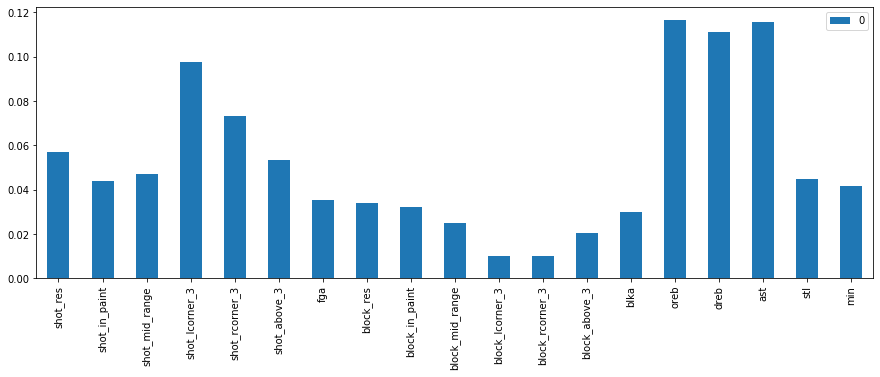

In [23]:
trained_rf_clf = rf_gridsearch.best_estimator_.steps[0][1]
ax = pd.DataFrame(trained_rf_clf.feature_importances_).plot(kind='bar', figsize=(15,5))
ax.set_xticklabels(X_train.columns.to_list());

### Pickling RF model for deployment
We are choosing the random forest model over XGBoost because inference is faster, and these two estimators have near identical accuracy.

In [27]:
# Since the pipeline only consists of the classifier, we'll grab just that
rf_trained_clf = rf_gridsearch.best_estimator_[0]

# Testing predict
rf_trained_clf.predict(X_test[:5])

with open('app/app/model/trained_rf_0.774_aug_16.pickle', 'wb') as f:
    p = pickle.dumps(rf_trained_clf)
    f.write(p)

## Conclusion

#### Non-parametric models outperform on our dataset
Through this exercise, we discovered that a tuned XGBoost model has the best performance, followed by random forest and logistic regression. Surprisingly, logistic regression only performed marginally better than the baseline decision tree classifier. My hypothesis is that logistic regression being a parametric linear classifier did not fit the non-linear relationship exhibited in the data well enough. This is in direct contrast with the tree based, non-parametric models.

#### Small forwards are the most versatile players
Small forward is the most difficult player position to predict, and often gets confused with point guards and shooting guards. This is because SFs are the most versatile position out of all basketball positions[1].

Small forwards are responsible for scoring points, defending and often as secondary or tertiary rebounders behind the power forward and center, although a few have considerable passing responsibilities. Many small forwards in professional basketball are prolific scorers.

[1] Versatility is key for small forwards 
https://www.espn.com/college-sports/recruiting/news/story?id=2677310